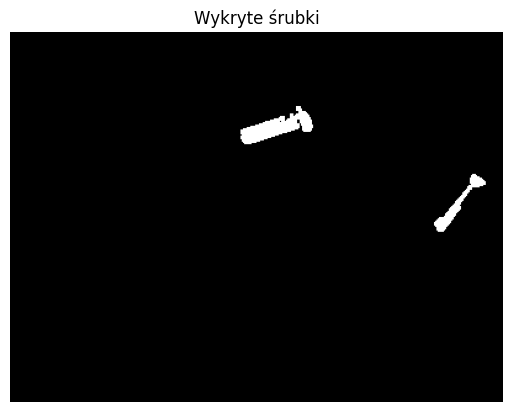

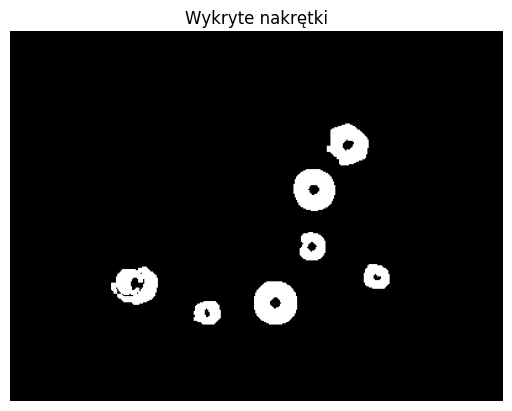

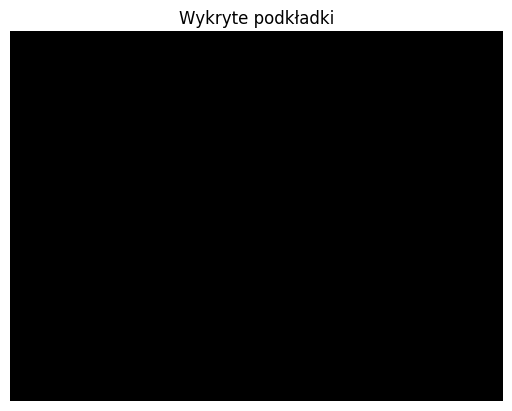

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Pobranie obrazu, jeśli nie istnieje
if not os.path.exists("details.png"):
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/details.png --no-check-certificate

# Wczytanie obrazu i jego wstępne przetwarzanie
original_image = cv2.imread('details.png', cv2.IMREAD_GRAYSCALE)
blurred_image = cv2.medianBlur(original_image, 3)  # Rozmycie medianowe dla redukcji szumów

# Operacja morfologiczna Black-hat
structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
blackhat_image = cv2.morphologyEx(blurred_image, cv2.MORPH_BLACKHAT, structuring_element)

# Binarna segmentacja obrazu
binary_image = np.where(blackhat_image < 60, 0, 1).astype('uint8')

# Dylatacja
dilated_image = cv2.dilate(binary_image, np.ones((3, 3), np.uint8))

# Indeksacja obiektów
num_labels, labeled_image, _, centroids = cv2.connectedComponentsWithStats(dilated_image)

# Wykrycie poszczególnych części na podstawie ich cech
screws_image = np.zeros_like(original_image)
nuts_image = np.zeros_like(original_image)
washers_image = np.zeros_like(original_image)

# Wyznaczenie parametrów dla detekcji
moments = [cv2.moments((labeled_image == i).astype('uint8')) for i in range(1, num_labels)]
hu_moments = [cv2.HuMoments(moment) for moment in moments]

for i, (moment, hu_moment, centroid) in enumerate(zip(moments, hu_moments, centroids[1:])):
    if 319 < moment['m00'] < 860 and hu_moment[0][0] > 0.2 and hu_moment[1][0] > 0.1:  # Warunki dla śrubek
        screws_image += (labeled_image == i + 1).astype('uint8')
    elif (300 < moment['m00'] < 900 and 0.09 < hu_moment[0][0] < 0.25) or \
         (700 < moment['m00'] < 1300 and 0.15 < hu_moment[0][0] < 0.22):  # Warunki dla nakrętek
        nuts_image += (labeled_image == i + 1).astype('uint8')
    elif (300 < moment['m00'] < 1200 and 0.09 < hu_moment[0][0] < 0.3 and 
          hu_moment[1][0] < 0.15 and hu_moment[2][0] < 0.02):  # Warunki dla podkładek
        washers_image += (labeled_image == i + 1).astype('uint8')

# Wyświetlenie wykrytych części
plt.imshow(screws_image, 'gray')
plt.title('Wykryte śrubki')
plt.axis('off')
plt.show()

plt.imshow(nuts_image, 'gray')
plt.title('Wykryte nakrętki')
plt.axis('off')
plt.show()

plt.imshow(washers_image, 'gray')
plt.title('Wykryte podkładki')
plt.axis('off')
plt.show()
